# Laplace on a sinuisoidal toy example

In [112]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create training and test data

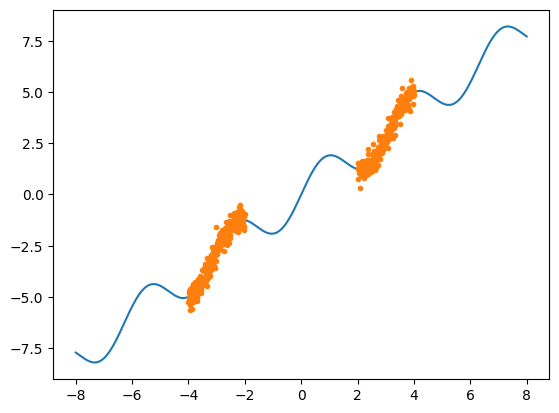

In [160]:
def f(x):
    # y = np.sin(2*x) + x + 0.3 * np.sin(50*x)
    y = np.sin(2 * x) + x
    return y


N = 1000
x_train = np.linspace(-4, 4, N)
x_train_all = x_train
mask = (x_train > 2) | (x_train < -2)
x_train_masked = x_train[~mask]
x_train = x_train[mask]
y_train = f(x_train) + 0.3 * np.random.randn(len(x_train))

x_test = np.linspace(-8, 8, 2 * N)
y_test = f(x_test)

# def get_sinusoid_example(n_data=150, sigma_noise=0.3, batch_size=150):
#     # create simple sinusoid data set
#     X_train = (torch.rand(n_data) * 8).unsqueeze(-1)
#     y_train = torch.sin(X_train) + torch.randn_like(X_train) * sigma_noise
#     X_test = torch.linspace(-5, 13, 500).unsqueeze(-1)
#     y_test = torch.sin(X_test)
#     return X_train, y_train, X_test.numpy().reshape(-1), y_test.numpy().reshape(-1)

# x_train, y_train, x_test, y_test = get_sinusoid_example()

plt.plot(x_test, y_test, "-")
plt.plot(x_train, y_train, ".")

# Define model, training and evaluation loops


In [161]:
def make_mlp(input_dim, hidden_dim, output_dim, num_layers):
    layers = []
    layers.append(nn.Linear(input_dim, hidden_dim))
    layers.append(nn.Tanh())
    for _ in range(num_layers - 2):
        layers.append(nn.Linear(hidden_dim, hidden_dim, bias=True))
        layers.append(nn.Tanh())
    layers.append(nn.Linear(hidden_dim, output_dim, bias=True))

    return nn.Sequential(*layers)


def train_model(model, epochs, x, y, device):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    x, y = x.to(device), y.to(device)

    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    loss_history = []
    for i in range(epochs):
        optimizer.zero_grad()

        pred = model(x)
        loss = torch.mean(torch.mean((pred - y) ** 2, dim=-1))
        loss.backward()
        optimizer.step()

        if i % 500 == 0:
            print(f"Epoch {i}, loss {loss.item()}")

        loss_history.append(loss.item())

    return {"loss_history": loss_history}


def test_model(model, x_test, device):
    model.eval()
    x = torch.tensor(x_test, dtype=torch.float32)
    x = x.to(device).reshape(-1, 1)

    with torch.no_grad():
        pred = model(x)

    return {"pred": pred}

# Train model

Epoch 0, loss 10.30199909210205
Epoch 500, loss 0.17666885256767273
Epoch 1000, loss 0.09645478427410126
Epoch 1500, loss 0.0954386442899704
Epoch 2000, loss 0.0949825868010521
Epoch 2500, loss 0.09450416266918182
Epoch 3000, loss 0.09396731853485107
Epoch 3500, loss 0.09342466294765472
Epoch 4000, loss 0.0929723009467125
Epoch 4500, loss 0.09267514199018478


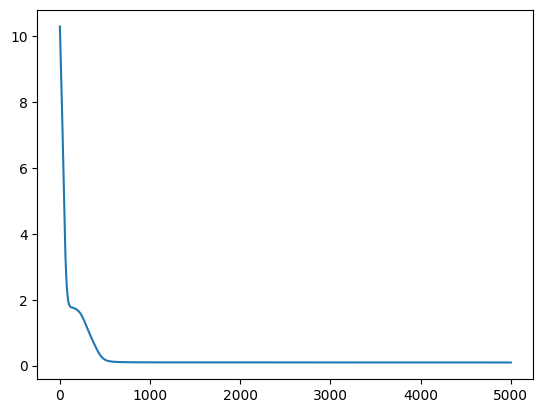

In [162]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = make_mlp(1, 16, 1, 4)
model = model.to(device)

out = train_model(model, 5000, x_train, y_train, device)

plt.plot(out["loss_history"])
plt.show()

# Show model fit

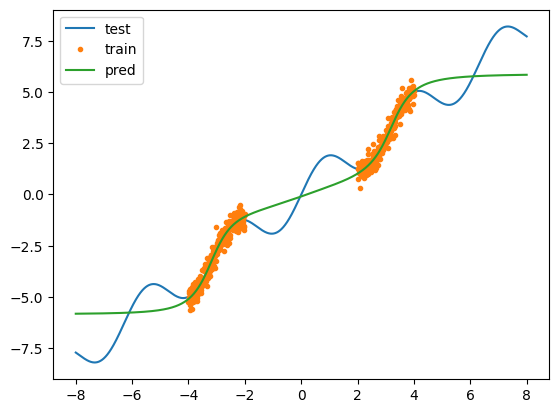

In [163]:
out = test_model(model, x_test, device)

plt.plot(x_test, y_test, "-", label="test")
plt.plot(x_train, y_train, ".", label="train")
plt.plot(x_test, out["pred"].cpu().numpy(), label="pred")
plt.legend()
plt.show()

# Perform Laplace Approximation on the model

In [167]:
from laplace import Laplace

# User-specified LA flavor
la = Laplace(model, 'regression',
             subset_of_weights='all',
             hessian_structure='diag')

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1),
        torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    ),
    batch_size=100,
)
la.fit(train_loader)
# la.optimize_prior_precision(method='CV', val_loader=train_loader)

# Visualize Laplace predictions

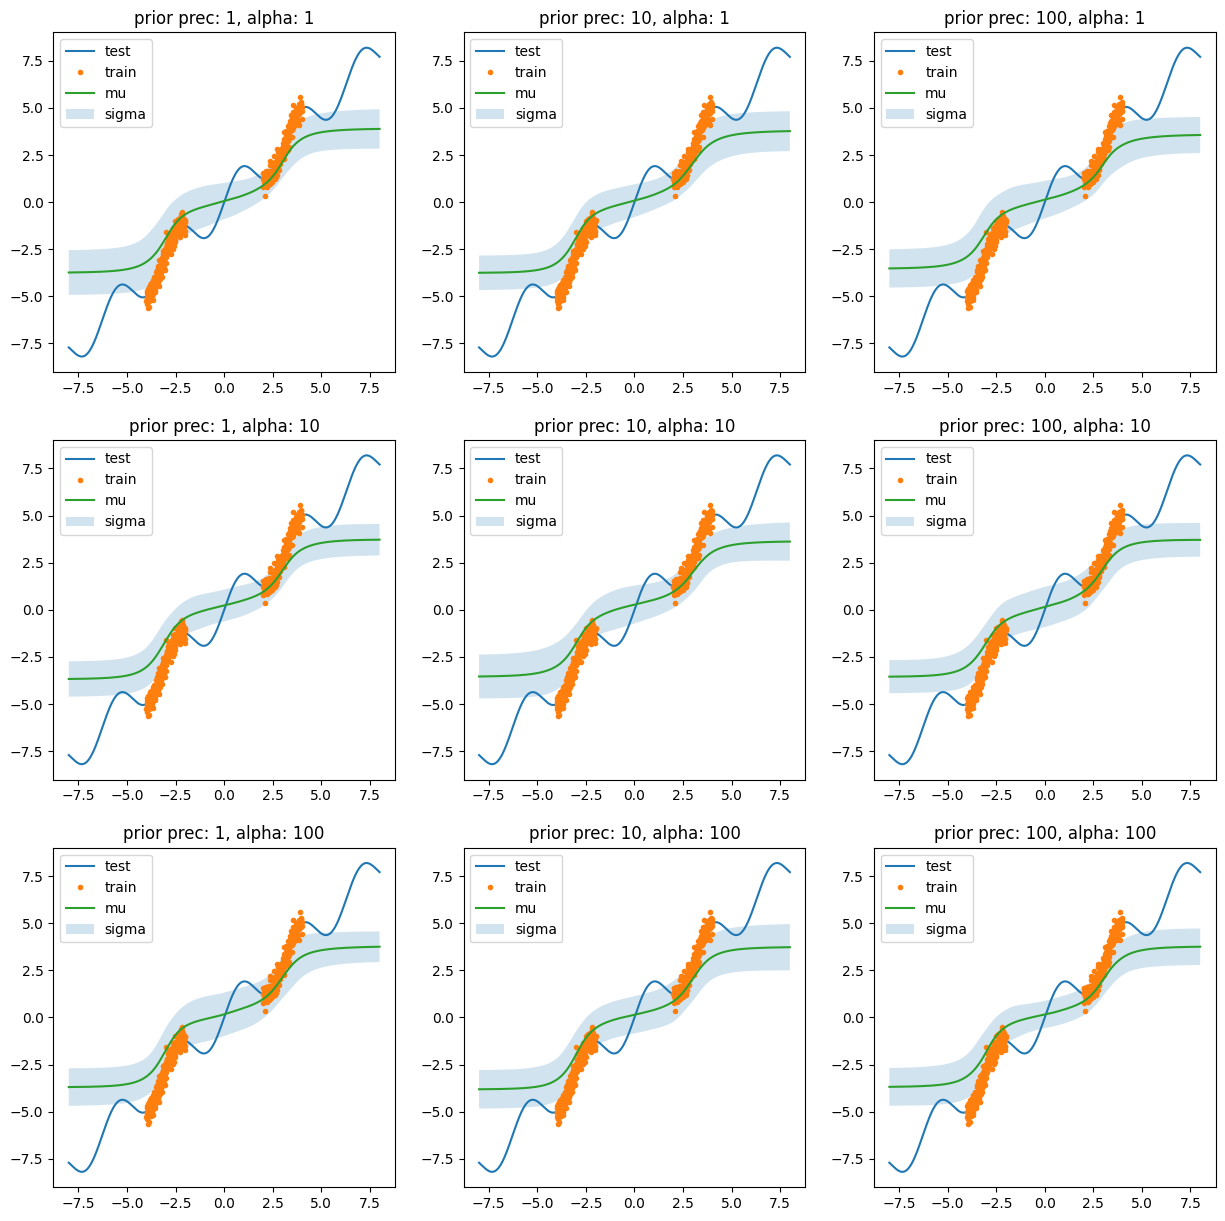

In [168]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for j, alpha in enumerate([1, 10, 100]):
    for i, prior_prec in enumerate([1, 10, 100]):
        model_input = torch.from_numpy(x_test.reshape(-1, 1)).type(torch.float32).to(device)
        mu, sigma = la(model_input, pred_type="nn")

        mu = mu.cpu().numpy().reshape(-1)
        sigma = sigma.cpu().numpy().reshape(-1)

        ax[j, i].plot(x_test, y_test, "-", label="test")
        ax[j, i].plot(x_train, y_train, ".", label="train")
        ax[j, i].plot(x_test, mu, label="mu")
        ax[j, i].fill_between(x_test, mu - sigma, mu + sigma, alpha=0.2, label="sigma")
        ax[j, i].legend()
        ax[j, i].set_title(f"prior prec: {prior_prec}, alpha: {alpha}")
plt.show()

# Linearized Laplace predictions

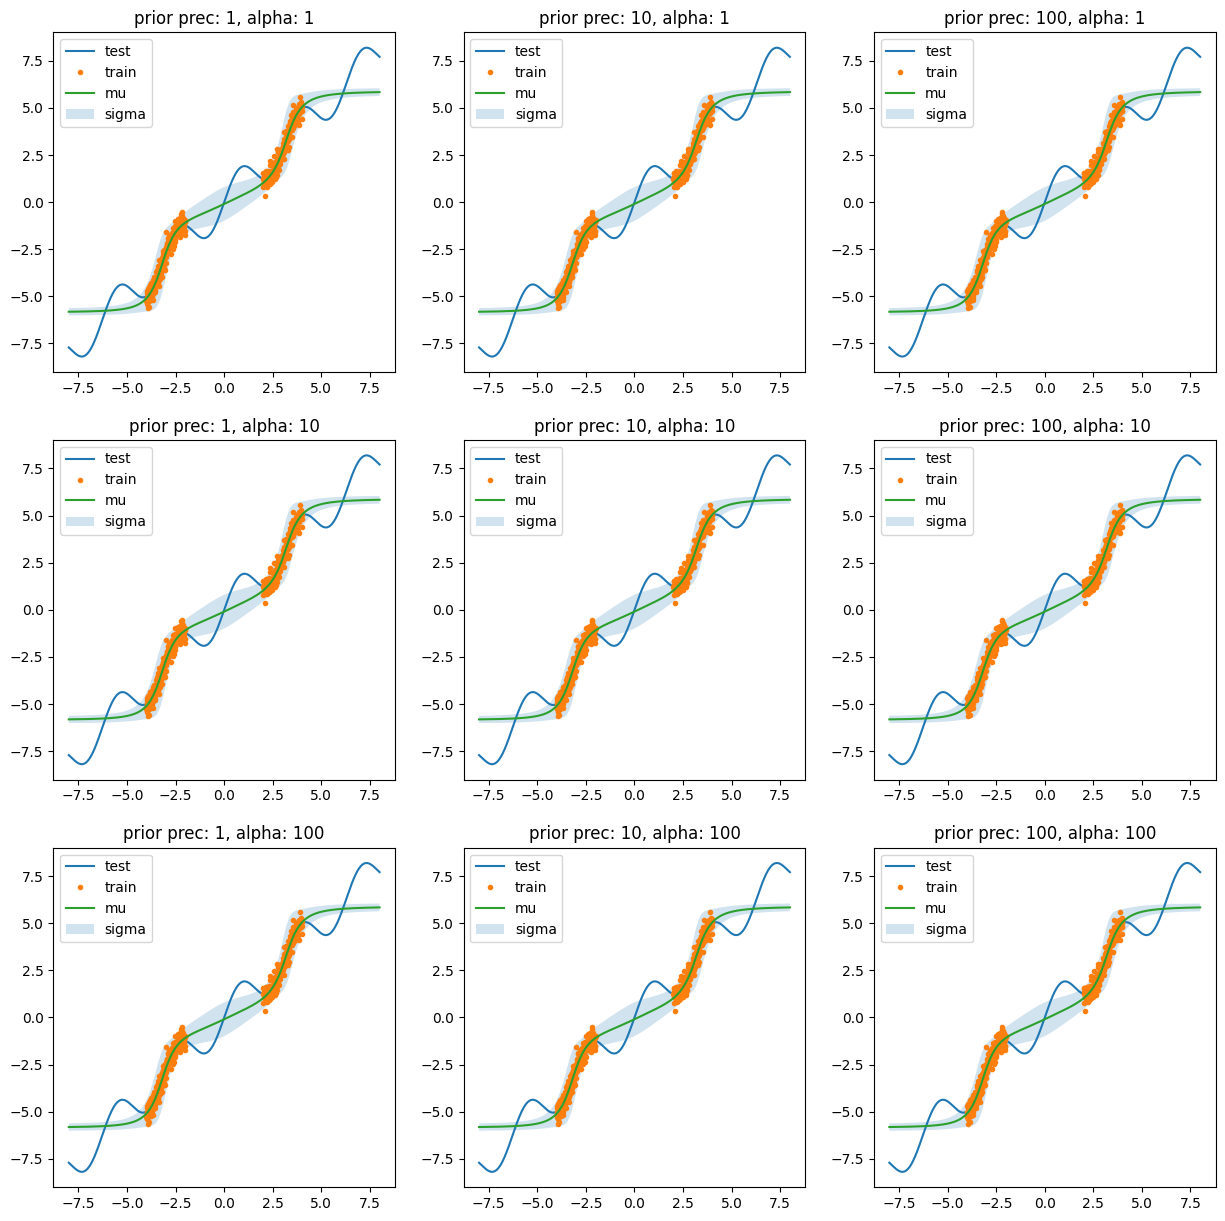

In [169]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for j, alpha in enumerate([1, 10, 100]):
    for i, prior_prec in enumerate([1, 10, 100]):
        model_input = torch.from_numpy(x_test.reshape(-1, 1)).type(torch.float32).to(device)
        mu, sigma = la(model_input, pred_type="glm")

        mu = mu.cpu().numpy().reshape(-1)
        sigma = sigma.cpu().numpy().reshape(-1)

        ax[j, i].plot(x_test, y_test, "-", label="test")
        ax[j, i].plot(x_train, y_train, ".", label="train")
        ax[j, i].plot(x_test, mu, label="mu")
        ax[j, i].fill_between(x_test, mu - sigma, mu + sigma, alpha=0.2, label="sigma")
        ax[j, i].legend()
        ax[j, i].set_title(f"prior prec: {prior_prec}, alpha: {alpha}")
plt.show()